# Comparing model reports

We've used logistic regression models and gradient boosted trees. It's time to compare these two to see which model will be used to make the final predictions.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, roc_curve, roc_auc_score
from sklearn.calibration import calibration_curve

In [2]:
cr_loan_prep = pd.read_csv("cr_loan_prep.csv", index_col=0)

In [3]:
X = cr_loan_prep.drop(columns=['loan_status'])
y = cr_loan_prep['loan_status']

# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

# Train a model
clf_lr = LogisticRegression(solver='lbfgs').fit(X_train, np.ravel(y_train))
clf_gbt = xgb.XGBClassifier().fit(X_train, np.ravel(y_train))

# Predict with a model
lr_proba = clf_lr.predict_proba(X_test)
gbt_proba = clf_gbt.predict_proba(X_test)
lr_preds = clf_lr.predict(X_test)
gbt_preds = clf_gbt.predict(X_test)

preds_df_lr = pd.concat([pd.Series(lr_proba[:,1]), pd.Series(lr_preds)], axis = 1)
preds_df_lr.rename(columns={0:'prob_default', 1:'loan_status'}, inplace=True)
preds_df_lr['loan_status'] = preds_df_lr['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)
preds_df_gbt = pd.concat([pd.Series(gbt_proba[:,1]), pd.Series(gbt_preds)], axis = 1)
preds_df_gbt.rename(columns={0:'prob_default', 1:'loan_status'}, inplace=True)

In [4]:
# Print the logistic regression classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df_lr['loan_status'], target_names=target_names))

# Print the gradient boosted tree classification report
print(classification_report(y_test, preds_df_gbt['loan_status'], target_names=target_names))

# Print the default F-1 scores for the logistic regression
print(precision_recall_fscore_support(y_test, preds_df_lr['loan_status'], average = 'macro')[2])

# Print the default F-1 scores for the gradient boosted tree
print(precision_recall_fscore_support(y_test, preds_df_gbt['loan_status'], average = 'macro')[2])

              precision    recall  f1-score   support

 Non-Default       0.85      0.93      0.89      9177
     Default       0.63      0.44      0.52      2609

    accuracy                           0.82     11786
   macro avg       0.74      0.68      0.70     11786
weighted avg       0.80      0.82      0.81     11786

              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      9177
     Default       0.94      0.73      0.82      2609

    accuracy                           0.93     11786
   macro avg       0.94      0.86      0.89     11786
weighted avg       0.93      0.93      0.93     11786

0.7041770023175149
0.8899544074006942


There is a noticeable difference between these two models. This means the tree model is better in all of these aspects. Let's check the ROC curve.

# Comparing with ROCs

We should use ROC charts and AUC scores to compare the two models. Sometimes, visuals can really help we and potential business users understand the differences between the various models under consideration.

With the graph in mind, we will be more equipped to make a decision. The lift is how far the curve is from the random prediction. The AUC is the area between the curve and the random prediction. The model with more lift, and a higher AUC, is the one that's better at making predictions accurately.

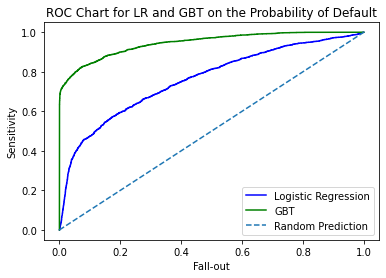

In [5]:
# ROC chart components
fallout_lr, sensitivity_lr, thresholds_lr = roc_curve(y_test, lr_proba[:,1])
fallout_gbt, sensitivity_gbt, thresholds_gbt = roc_curve(y_test, gbt_proba[:,1])

# ROC Chart with both
plt.plot(fallout_lr, sensitivity_lr, color = 'blue', label='%s' % 'Logistic Regression')
plt.plot(fallout_gbt, sensitivity_gbt, color = 'green', label='%s' % 'GBT')
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("ROC Chart for LR and GBT on the Probability of Default")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

In [6]:
# Print the logistic regression AUC with formatting
print("Logistic Regression AUC Score: %0.2f" % roc_auc_score(y_test, lr_proba[:,1]))

# Print the gradient boosted tree AUC with formatting
print("Gradient Boosted Tree AUC Score: %0.2f" % roc_auc_score(y_test, gbt_proba[:,1]))

Logistic Regression AUC Score: 0.76
Gradient Boosted Tree AUC Score: 0.95


Look at the ROC curve for the gradient boosted tree. Not only is the lift much higher, the calculated AUC score is also quite a bit higher. It's beginning to look like the gradient boosted tree is best. Let's check the calibration to be sure.

# Calibration curves

In [7]:
frac_of_pos_lr, mean_pred_val_lr = calibration_curve(y_test, lr_proba[:,1], n_bins=20)
frac_of_pos_gbt, mean_pred_val_gbt = calibration_curve(y_test, gbt_proba[:,1], n_bins=20)

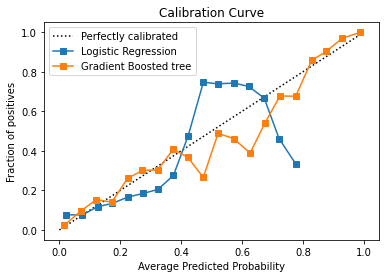

In [8]:
# Add the calibration curve for the gradient boosted tree
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')    
plt.plot(mean_pred_val_lr, frac_of_pos_lr,
         's-', label='%s' % 'Logistic Regression')
plt.plot(mean_pred_val_gbt, frac_of_pos_gbt,
         's-', label='%s' % 'Gradient Boosted tree')
plt.ylabel('Fraction of positives')
plt.xlabel('Average Predicted Probability')
plt.legend()
plt.title('Calibration Curve')
plt.show()

Notice that for the logistic regression, the calibration for probabilities starts off great but then gets more erratic as it the average probability approaches 0.4. Something similar happens to the gradient boosted tree around 0.5, but the model eventually stabilizes. We will be focusing on only the gbt model from now on.

# Acceptance rates

Setting an acceptance rate and calculating the threshold for that rate can be used to set the percentage of new loans we want to accept.

In [9]:
preds = pd.DataFrame(gbt_proba[:,1], columns=['prob_default'])

# Check the statistics of the probabilities of default
print(preds['prob_default'].describe())

# Calculate the threshold for a 85% acceptance rate
threshold_85 = np.quantile(preds['prob_default'], 0.85)

# Apply acceptance rate threshold
preds['pred_loan_status'] = preds['prob_default'].apply(lambda x: 1 if x > threshold_85 else 0)

# Print the counts of loan status after the threshold
print(preds['pred_loan_status'].value_counts())

count    11786.000000
mean         0.213060
std          0.344005
min          0.000003
25%          0.009149
50%          0.042211
75%          0.183035
max          0.999994
Name: prob_default, dtype: float64
0    10018
1     1768
Name: pred_loan_status, dtype: int64


In the results of *.describe()* we see how it's not until 75% that we start to see double-digit numbers, this occurs because the majority of our test set is non-default loans.

# Visualizing quantiles of acceptance

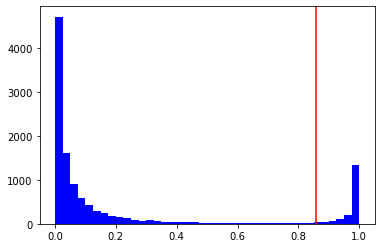

In [10]:
# Plot the predicted probabilities of default
plt.hist(gbt_proba[:,1], color = 'blue', bins = 40)

# Calculate the threshold with quantile
threshold = np.quantile(gbt_proba[:,1], 0.85)

# Add a reference line to the plot for the threshold
plt.axvline(x = threshold, color = 'red')
plt.show()

Here, we can see where the threshold is on the range of predicted probabilities. Not only can we see how many loans will be accepted (left side), but also how many loans will be rejected (right side).

# Bad rates

In [11]:
test_pred_df = preds_df_gbt
test_pred_df.rename(columns={'loan_status':'pred_loan_status'}, inplace=True)
test_pred_df['true_loan_status'] = y_test.values

In [12]:
# Print the top 5 rows of the new data frame
print(test_pred_df.head())

# Create a subset of only accepted loans
accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]

# Calculate the bad rate
print(np.sum(accepted_loans['true_loan_status']) / accepted_loans['true_loan_status'].count())

   prob_default  pred_loan_status  true_loan_status
0      0.011106                 0                 0
1      0.167985                 0                 0
2      0.002628                 0                 0
3      0.063230                 0                 0
4      0.189694                 0                 0
0.07199918066366243


This bad rate doesn't look half bad! The bad rate with the threshold set by the 85% quantile() is about 7.2%. This means that of all the loans we've decided to accept from the test set, only 7.2% were actual defaults! If we accepted all loans, the percentage of defaults would be around 22%.

# Acceptance rate impact

In [13]:
test_pred_df['loan_amnt'] = X_test['loan_amnt'].values

# Print the statistics of the loan amount column
print(test_pred_df['loan_amnt'].describe())

# Store the average loan amount
avg_loan = np.mean(test_pred_df['loan_amnt'])

# Set the formatting for currency, and print the cross tab
pd.options.display.float_format = '${:,.2f}'.format
print(pd.crosstab(test_pred_df['true_loan_status'],
                 test_pred_df['pred_loan_status']).apply(lambda x: x * avg_loan, axis = 0))

count    11786.000000
mean      9534.182505
std       6247.338130
min        500.000000
25%       5000.000000
50%       8000.000000
75%      12000.000000
max      35000.000000
Name: loan_amnt, dtype: float64
pred_loan_status              0              1
true_loan_status                              
0                $86,389,227.67  $1,105,965.17
1                 $6,702,530.30 $18,172,151.85


With this, we can see that our bad rate of about 7.2% represents an estimated loan value of about 6.7 million dollars. This may seem like a lot at first, but compare it to the total value of non-default loans!

# Making the strategy table

Before we implement a strategy, we should first create a strategy table containing all the possible acceptance rates we wish to look at along with their associated bad rates and threshold values. This way, we can begin to see each part of your strategy and how it affects our portfolio.

In [14]:
accept_rates = [1, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]
thresholds = []
bad_rates = []

In [15]:
# Populate the arrays for the strategy table with a for loop
for rate in accept_rates:
    # Calculate the threshold for the acceptance rate
    thresh = np.quantile(preds['prob_default'], rate).round(3)
    # Add the threshold value to the list of thresholds
    thresholds.append(np.quantile(preds['prob_default'], rate).round(3))
    # Reassign the loan_status value using the threshold
    test_pred_df['pred_loan_status'] = test_pred_df['prob_default'].apply(lambda x: 1 if x > thresh else 0)
    # Create a set of accepted loans using this acceptance rate
    accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]
    # Calculate and append the bad rate using the acceptance rate
    bad_rates.append(np.sum((accepted_loans['true_loan_status']) / len(accepted_loans['true_loan_status'])).round(3))

In [16]:
pd.options.display.float_format = None
# Create a data frame of the strategy table
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates),
                        columns = ['Acceptance Rate','Threshold','Bad Rate'])

# Print the entire table
print(strat_df)

    Acceptance Rate  Threshold  Bad Rate
0              1.00      1.000     0.221
1              0.95      0.995     0.179
2              0.90      0.983     0.134
3              0.85      0.857     0.085
4              0.80      0.309     0.062
5              0.75      0.183     0.050
6              0.70      0.125     0.042
7              0.65      0.093     0.035
8              0.60      0.070     0.029
9              0.55      0.054     0.024
10             0.50      0.042     0.021
11             0.45      0.033     0.019
12             0.40      0.025     0.016
13             0.35      0.019     0.013
14             0.30      0.013     0.009
15             0.25      0.009     0.006
16             0.20      0.005     0.003
17             0.15      0.002     0.000
18             0.10      0.001     0.000
19             0.05      0.000     0.000


This uses our specific predictions on the credit data, and can be used to see the acceptance rates, bad rates, and financial impact all at once. One of these values has the highest estimated value.

# Visualizing the strategy

We should check at the distribution of each column with a box plot. If the distribution of Acceptance Rate looks the same as the Bad Rate column, that could be a problem. That means that the model's calibration is likely much worse than you thought.

We can also visualize the strategy curve with a line plot. The Acceptance Rate would be the independent variable with the Bad Rate as the dependent variable.

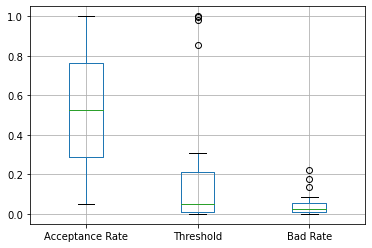

In [17]:
# Visualize the distributions in the strategy table with a boxplot
strat_df.boxplot()
plt.show()

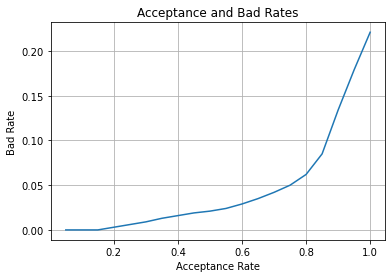

In [18]:
# Plot the strategy curve
plt.plot(strat_df['Acceptance Rate'], strat_df['Bad Rate'])
plt.xlabel('Acceptance Rate')
plt.ylabel('Bad Rate')
plt.title('Acceptance and Bad Rates')
plt.axes().yaxis.grid()
plt.axes().xaxis.grid()
plt.show()

The boxplot shows us the distribution for each column. Look at the strategy curve. The bad rates are very low up until the acceptance rate *0.6* where they suddenly increase. This suggests that many of the accepted defaults may have a *prob_default* value between *0.6* and *0.8*.

# Estimated value profiling

| Column      | Description |
| :---        | :---        |
| Num Accepted Loans      | The number of accepted loans based on the threshold       |
| Avg Loan Amnt   | The average loan amount of the entire test set        |
| Estimated value   | The estimated net value of non-defaults minus defaults        |

In [19]:
# Print the contents of the strategy df
print(strat_df)

    Acceptance Rate  Threshold  Bad Rate
0              1.00      1.000     0.221
1              0.95      0.995     0.179
2              0.90      0.983     0.134
3              0.85      0.857     0.085
4              0.80      0.309     0.062
5              0.75      0.183     0.050
6              0.70      0.125     0.042
7              0.65      0.093     0.035
8              0.60      0.070     0.029
9              0.55      0.054     0.024
10             0.50      0.042     0.021
11             0.45      0.033     0.019
12             0.40      0.025     0.016
13             0.35      0.019     0.013
14             0.30      0.013     0.009
15             0.25      0.009     0.006
16             0.20      0.005     0.003
17             0.15      0.002     0.000
18             0.10      0.001     0.000
19             0.05      0.000     0.000


In [20]:
strat_df['Num Accepted Loans'] = (strat_df['Threshold']*X_test.shape[0]).round(0)
strat_df['Avg Loan Amnt'] = X_test['loan_amnt'].mean()
strat_df['Estimated Value'] = (1-strat_df['Bad Rate'])*strat_df['Num Accepted Loans']*strat_df['Avg Loan Amnt']

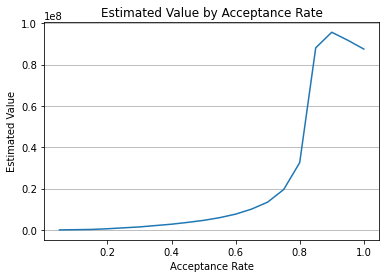

In [21]:
# Create a line plot of estimated value
plt.plot(strat_df['Acceptance Rate'],strat_df['Estimated Value'])
plt.title('Estimated Value by Acceptance Rate')
plt.xlabel('Acceptance Rate')
plt.ylabel('Estimated Value')
plt.axes().yaxis.grid()
plt.show()

In [22]:
# Print the row with the max estimated value
print(strat_df.loc[strat_df['Estimated Value'] == np.max(strat_df['Estimated Value'])])

   Acceptance Rate  Threshold  Bad Rate  Num Accepted Loans  Avg Loan Amnt  \
2              0.9      0.983     0.134             11586.0    9534.182505   

   Estimated Value  
2     9.566099e+07  


With our credit data and our estimated averag loan value, we clearly see that the acceptance rate 0.9 has the highest potential estimated value. Normally, the allowable bad rate is set, but we can use analyses like this to explore other options.

# Total expected loss

It's time to estimate the total expected loss given all our decisions. The data frame *test_pred_df* has the probability of default for each loan and that loan's value. Use these two values to calculate the expected loss for each loan. Then, we can sum those values and get the total expected loss.

We will assume that the exposure is the full value of the loan, and the loss given default is 100%. This means that a default on each the loan is a loss of the entire amount.

In [23]:
test_pred_df['loss_given_default'] = 1.0
test_pred_df.drop(columns=['true_loan_status'], inplace=True)

# Print the first five rows of the data frame
print(test_pred_df.head())

# Calculate the bank's expected loss and assign it to a new column
test_pred_df['expected_loss'] = test_pred_df['prob_default'] * test_pred_df['loan_amnt'] * test_pred_df['loss_given_default']

# Calculate the total expected loss to two decimal places
tot_exp_loss = round(np.sum(test_pred_df['expected_loss']),2)

# Print the total expected loss
print('Total expected loss: ', '${:,.2f}'.format(tot_exp_loss))

   prob_default  pred_loan_status  loan_amnt  loss_given_default
0      0.011106                 1       9000                 1.0
1      0.167985                 1       4000                 1.0
2      0.002628                 1       6300                 1.0
3      0.063230                 1      12400                 1.0
4      0.189694                 1       7500                 1.0
Total expected loss:  $27,044,734.57


This is the total expected loss for the entire portfolio using the gradient boosted tree. 27 million may seem like a lot, but the total expected loss would have been over 28 million with the logistic regression.